In [83]:
#Importing the neccecary Librarues
import numpy as np  
import pandas as pd 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

import warnings
warnings.simplefilter('ignore')

#Reading the data
df = pd.read_csv('./data/data.csv')

#Cleaning the data
df['time_id'] = pd.to_datetime(df['time_id'], format='%Y/%m/%d %H:%M')
df.set_index('time_id',inplace=True)

x_scaled = StandardScaler()
x_scaled = x_scaled.fit_transform(x)
dfNorm = pd.DataFrame(x_scaled, columns=df.columns)

# stationary testing of data 
def test_stationary(data,column='',significance=0.05,series=False):
    if series:
        adf_test = adfuller(data,autolag='AIC')
    else:
        adf_test = adfuller(data[column],autolag='AIC')
    p_value = adf_test[1]
    if p_value <= significance:
        results = "Stationary"
    else:
        results = "Non-Stationary"
    return results

test_stationary(df,'ping_ms')

def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace = True)
    return differenced_data
df['ping_ms'] = differencing(df, 'ping_ms', 1)


max_lag = 120
var_model = VAR(data)

lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic

print(selected_lag)

66


In [2]:
import numpy as np  
import pandas as pd 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
 
import warnings
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv('./data/data.csv')
df.head()

,time_id,ping_ms,temperature_c,humidity_p
0,2021-09-30 21:08:02,17.28,25,35
1,2021-09-30 21:09:02,17.73,23,40
2,2021-09-30 21:10:01,18.59,22,41
3,2021-09-30 21:12:02,16.73,22,42
4,2021-09-30 21:13:02,18.12,22,42


In [12]:
df['time_id'] = pd.to_datetime(df['time_id'], format='%Y/%m/%d %H:%M')
df.set_index('time_id',inplace=True)

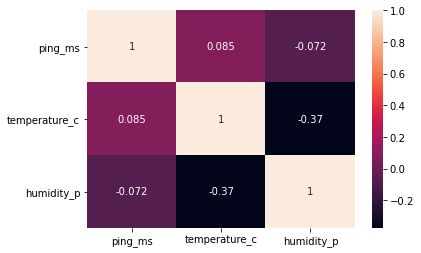

In [34]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130337 entries, 2021-09-30 21:08:02 to 2022-01-10 13:32:02
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ping_ms        130337 non-null  float64
 1   temperature_c  130337 non-null  int64  
 2   humidity_p     130337 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 4.0 MB


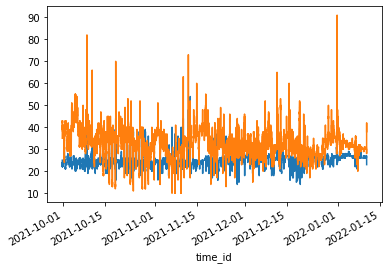

In [35]:
df.temperature_c.plot()
df.humidity_p.plot()

In [14]:
x = df.values

In [16]:
x_scaled = StandardScaler()
x_scaled = x_scaled.fit_transform(x)
dfNorm = pd.DataFrame(x_scaled, columns=df.columns)
print(dfNorm.shape)
dfNorm.head()

(130337, 3)


,ping_ms,temperature_c,humidity_p
0,-0.157514,-0.105148,0.370616
1,-0.156111,-0.963220,1.235959
2,-0.153431,-1.392256,1.409027
3,-0.159228,-1.392256,1.582096
4,-0.154896,-1.392256,1.582096


In [17]:
# stationary testing of data 
def test_stationary(data,column='',significance=0.05,series=False):
    if series:
        adf_test = adfuller(data,autolag='AIC')
    else:
        adf_test = adfuller(data[column],autolag='AIC')
    p_value = adf_test[1]
    if p_value <= significance:
        results = "Stationary"
    else:
        results = "Non-Stationary"
    return results

In [48]:
test_stationary(df,'ping_ms')

'Stationary'

In [47]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace = True)
    return differenced_data
df['ping_ms'] = differencing(df, 'ping_ms', 1)

In [65]:
data = df.drop(columns='ping_ms')

In [66]:
from statsmodels.tsa.api import VAR
max_lag = 120
var_model = VAR(data)

lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic

print(selected_lag)

24


In [67]:
selected_lag = 24

In [68]:
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions,threshold
var = VAR(df)
var_fitresults = var.fit(selected_lag)
squared_errors = var_fitresults.resid.sum(axis=1) ** 2

In [69]:
predictions, threshold = find_anomalies(squared_errors)

In [72]:
data = df.iloc[selected_lag:, :]
data['Predictions'] = predictions.values
data

,ping_ms,temperature_c,humidity_p,Predictions
time_id,,,,
2021-09-30 21:35:02,0.46,23,41,0
2021-09-30 21:36:02,-0.02,23,41,0
2021-09-30 21:37:01,4.09,23,41,0
2021-09-30 21:38:01,-4.68,23,41,0
2021-09-30 21:39:02,0.80,23,42,0
...,...,...,...,...
2022-01-10 13:12:02,0.00,27,28,0
2022-01-10 13:13:02,0.00,27,28,0
2022-01-10 13:14:01,0.00,27,28,0


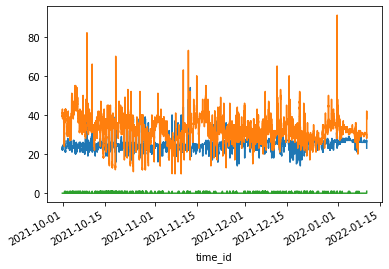

In [78]:
data.temperature_c.plot()
data.humidity_p.plot()
data.Predictions.plot()

In [81]:
predicted = data[data['Predictions']==1].index
final = df.drop(predicted, inplace = True)

KeyError: "[Timestamp('2021-10-01 15:37:01') Timestamp('2021-10-01 15:38:01')\n Timestamp('2021-10-01 23:12:02') ... Timestamp('2022-01-07 23:04:02')\n Timestamp('2022-01-10 13:31:13') Timestamp('2022-01-10 13:32:02')] not found in axis"

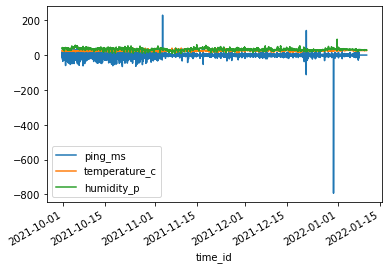

In [82]:
df.plot()